In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Read excel file, sheet excess returns
etfData = pd.read_excel('../data/proshares_analysis_data.xlsx', 'hedge_fund_series')
# Set the index to Date (rather than default 0 indexing)
etfData.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
etfData = etfData.set_index('Date')
# Display top rows for validation
etfData.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006489
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032465,-0.022144
2011-10-31,0.026858,0.043593,0.043320,0.050530,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028606,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001823


In [18]:
# 1: Report mean, volatility, and Sharpe ratio. Annualize
def portfolio_stats(data):
    # Calculate the mean and annualize
    mean = data.mean() * 12

    # Volatility = standard deviation
    # Annualize the result with sqrt(12)
    vol = data.std() * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio], 
        index = ['Mean', 'Volatility', 'Sharpe']), 4)
    
portfolio_stats(etfData)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Mean,0.0429,0.0257,0.0243,0.0140,0.0116
Volatility,0.0609,0.0569,0.0567,0.0592,0.0489
Sharpe,0.7038,0.4513,0.4283,0.2365,0.2366


In [19]:
# 2. Tail Risk
# Takes data and quantile, and returns:
#      Skewness
#      Excess Kurtosis
#      VaR (q) -> the q-th quantile of historic returns
#      CVaR (q) -> the mean of returns at or below the q-th quantile
#      Maximum drawdown 
def tail_risk_report(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['CVaR'] = df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['Drawdown Start'] = None
    report.loc['Drawdown End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['Drawdown Start', col] = (rolling_max.loc[:report.loc['Drawdown End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['Drawdown End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['Drawdown Start']).dt.days
        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None

    return round(report,4)

tail_risk_report(etfData, 0.05)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Skewness,-1.020683,-0.315513,-0.304807,-0.298573,-0.634129
Excess Kurtosis,6.163102,1.778696,1.741807,1.931106,1.913339
VaR,-0.025585,-0.029652,-0.029867,-0.031528,-0.021245
CVaR,-0.039205,-0.036865,-0.036763,-0.038482,-0.034401
Max Drawdown,-0.115473,-0.124302,-0.124388,-0.14072,-0.137714
Drawdown Start,2019-12-31,2021-06-30,2021-06-30,2021-06-30,2021-06-30
Drawdown End,2020-03-31,2022-09-30,2022-09-30,2022-09-30,2022-09-30
Recovery Date,2020-08-31,None,None,None,None
Recovery period (days),None,None,None,None,None


It is interesting to note in the above data that many of the indexes are currently in their max drawdown and have not yet begun to recover.

In [20]:
# 3. Regression based statistics against SPY
# First get SPY
factor_data = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name = 'merrill_factors')
factor_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
factor_data = factor_data.set_index('Date')
def regression_stats(df):
    reg_stats = pd.DataFrame(data = None, index = df.columns, columns = ['beta', 
                                                                         'Treynor Ratio', 
                                                                         'Information Ratio'])
    for col in df.columns:
        # Drop the NAs in y
        y = df[col].dropna()
        # Align the X with y - this is us including the intercept
        X = sm.add_constant(factor_data['SPY US Equity'].loc[y.index])
        reg = sm.OLS(y, X).fit()
        reg_stats.loc[col, 'beta'] = reg.params[1]
        # Treynor is calulated as mean/beta
        reg_stats.loc[col, 'Treynor Ratio'] = (df[col].mean() * 12) / reg.params[1]
        reg_stats.loc[col, 'Information Ratio'] = (reg.params[0] / reg.resid.std()) * np.sqrt(12)

    return reg_stats.astype(float).round(4)

regression_stats(etfData)

,beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.3500,0.1225,0.0130
MLEIFCTR Index,0.3549,0.0723,-0.7315
MLEIFCTX Index,0.3536,0.0687,-0.7846
HDG US Equity,0.3631,0.0386,-1.1237
QAI US Equity,0.2919,0.0397,-0.9838


- Beta < 1 indicates that for every dollar of SPY, the indexes go up by less than that dollar. Lower beta = less risk because of reverse slope.
- Treynor Ratio measures return based on systematic risk (like Sharpe but based on beta instead). Based on this analysis, the HFRIFWI Index has the best return for systematic risk compared to the others.
- The only Index with IR > 0 is HFRIFWI, indicating it's the only index which beat the market on this time frame


4. Relative Performance

<br/>   a) The preceding statistics show that all of the hedge-funds are less volatile than SPY, and that HFRIFWI was the only one to beat SPY in terms of returns.
<br/>   b) Though HDG has a higher mean, I would say that QAI performs better, because it has the higher Sharpe and information ratio.
<br/>   c) I would argue that HDG and ML do not capture the notable properties of HFRI. HFRI had the only positive information ratio, a higher Sharpe ratio, and was significantly more skewed. Additionally, HFRI had an excess kurtosis of more than three times the others.

MIN Correlation pair is ('HFRIFWI Index', 'QAI US Equity') with value 0.9999389069229563
MAX Correlation pair is ('MLEIFCTX Index', 'MLEIFCTR Index') with value 0.8384824348734503


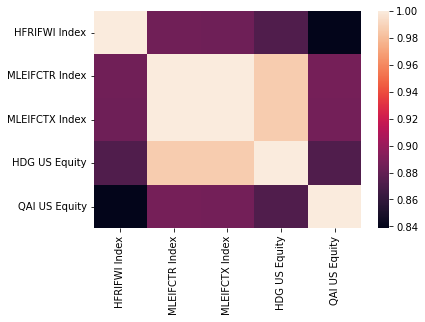

In [21]:
# 5. Display Correlation Matrix as heatmap
correlationMatrix = etfData.corr()
sns.heatmap(correlationMatrix)

# Find min and max correlations (remove 1)
correlationMatrix[correlationMatrix==1] = None
corr_rank = correlationMatrix.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min} with value {corr_rank[-1]}')
print(f'MAX Correlation pair is {pair_max} with value {corr_rank[0]}')

In [22]:
# 6. Replicate HFRI with the six factors listed on the "merrill_factors" tab.
# Get the HFRI data
HFRI = etfData['HFRIFWI Index']
# Include the constant
HFRI_with_constant = sm.add_constant(factor_data)
# Replicate HFRI with the merrill_factors data
model = sm.OLS(HFRI, HFRI_with_constant).fit()
# a) Report the intercept and betas
model.params.to_frame('Regression Parameters')

,Regression Parameters
const,0.001142
SPY US Equity,0.025589
USGG3M Index,0.834569
EEM US Equity,0.074135
EFA US Equity,0.105604
EUO US Equity,0.023240
IWM US Equity,0.147375


b) The betas seem realistic. There are no huge long/short positions, though USGG3M does have the largest position at 0.83.

In [23]:
# c) Report the R-squared
round(model.rsquared, 4)

0.8213

In [24]:
# d) Report the volatility of e^merr, (the tracking error.) Remember volatility = standard deviation annualized
#   NOTE:   Tracking error is a measure of financial performance that determines the difference between 
#           the return fluctuations of an investment portfolio and the return fluctuations of a chosen benchmark. 
#           The return fluctuations are primarily measured by standard deviations.
round(model.resid.std() * np.sqrt(12),4)

0.0258

In [25]:
from statsmodels.regression.rolling import RollingOLS
# 7. Examine the replication out-of-sample.
# Use previous 60 month to estimate regression equation, using rolling 60 to estimate
rolling_model = RollingOLS(HFRI, HFRI_with_constant,window=60)
rolling_betas = rolling_model.fit().params.copy()
rolling_betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Date,,,,,,,
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-05-31,0.004084,0.014981,-2.033076,0.108451,0.115181,0.033973,0.175357
2022-06-30,0.004204,0.011314,-2.009264,0.106422,0.111324,0.028605,0.181174
2022-07-31,0.004532,0.001035,-2.399443,0.118317,0.107350,0.020165,0.176503


<AxesSubplot: xlabel='Date'>

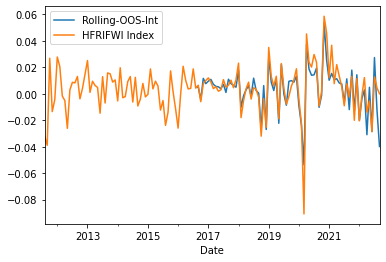

In [26]:
# Calculate the replication value
in_sample_replication = (rolling_betas * HFRI_with_constant).sum(axis=1,skipna=False)
out_of_sample_replication = (rolling_betas.shift() * HFRI_with_constant).sum(axis=1,skipna=False)
replication = etfData[['HFRIFWI Index']].copy()
replication['Rolling-OOS-Int'] = out_of_sample_replication
replication[['Rolling-OOS-Int','HFRIFWI Index']].plot()

The out of sample replication seems to do well. It appears highly correlated witth HFRI, with only minor variations in the last year or so.


In [27]:
# 8. Try a full-sample estimation, this time without an intercept
HFRI = etfData['HFRIFWI Index']
model_no_intercept = sm.OLS(HFRI,factor_data).fit()
# a) Report the regression betas. How do they compare to the betas of the model with the intercept?
betas = pd.DataFrame(model.params,columns=['With Intercept']).T
betas.loc['Without Intercept'] = model_no_intercept.params
betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
With Intercept,0.001142,0.025589,0.834569,0.074135,0.105604,0.023240,0.147375
Without Intercept,NaN,0.040448,1.551706,0.073052,0.100760,0.024909,0.144352


The betas are very similar, the largest difference being in the 3 month T-bills. There is also some small variation in SPY, but overall I would say the regression performance is very similar.

In [28]:
# b) Report the mean of the fitted value (annualized)
round(model_no_intercept.fittedvalues.mean(),4)*12

0.0348

In [29]:
# compare this to the mean of HFRI
round(etfData['HFRIFWI Index'].mean(),4)*12

0.0432

The mean of the fitted value is just slightly lower than the mean of the HFRI Index (-0.0084).

In [31]:
# c) Report the correlations of the fitted values.
replication['Model_No_Intercept'] = model_no_intercept.fittedvalues
replication['Model_With_Intercept'] = model.fittedvalues
replication.corr()

,HFRIFWI Index,Rolling-OOS-Int,Model_No_Intercept,Model_With_Intercep
HFRIFWI Index,1.000000,0.887358,0.905696,0.906244
Rolling-OOS-Int,0.887358,1.000000,0.984103,0.986613
Model_No_Intercept,0.905696,0.984103,1.000000,0.999395
Model_With_Intercep,0.906244,0.986613,0.999395,1.000000


If we want to replicate a Hedge Fund's return and then we should not include an intercept. If we only care about matching variation, then it doesn't matter if we include an intercept. Since Merrill and ProShares are trying to match returns, we can assume that they are not using an intercept.